## Background and Aim


>Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]





In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives.

This project is aimed at using machine learning tools to build a POI(person of interest, individual who was indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity) indentifier based on the Enron finacial and email dataset. Our dataset combines the public record of Enron emails and financial data with a hand-generated list of POI’s in the fraud case. Machine learning is an excellent tool for this kind of classification task as it can use patterns discovered from labeled data to infer the classes of new observations.



## The Enron Data Overview

This dataset contains 146 data points, each point has 21 features, most of features are float data, whereas 'poi' labels are boolean and 'email_address' values are string data type. There are two characteristics of this dataset that needs particular attention:
1. Note that out of 146 data points, there are only 18 POIs, indicates an imbalanced dataset. This will impact feature selection and algorithem tuning strategy.
2. Missing information for a person does not make this "missing information" as a tag of that person, to avoid false indentification, I will not use the features that contains too many missing data points.



In [96]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
### convert dict to dataframe
dt = pd.DataFrame.from_dict(data_dict, orient='index')
dt.replace('NaN', np.nan, inplace = True)    
    
dt.info()
    

print "There are ", np.sum(dt['poi'])," POIs in Enron Dataset."    

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

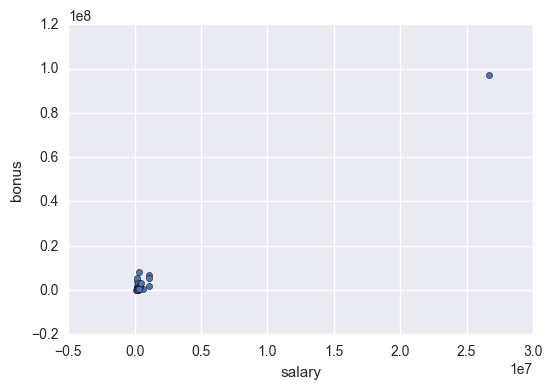

In [97]:
%matplotlib inline

###visualization for outliner identification
dt.plot.scatter(x = 'salary', y = 'bonus')

In [98]:
dt['salary'].idxmax()

'TOTAL'

In [99]:
dt.drop('TOTAL', inplace = True)

dt.drop('LOCKHART EUGENE E', inplace = True) #all NaN values
#dt['total_payments'].idxmax()

## Feature Selection/Engineering

>What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]


1. **Remove outliners**: Firstly I utilize visualization tool to checke the dataset, it indicates that 'TOTAL' was contained as a data point, so I removed it. 'LOCKHART EUGENE E' does not contain valid data, so it was removed too.

2. **Create new features**: the two features 'from_this_person_to_poi' and 'from_poi_to_this_person' are likely to be important tag for POI indentification, however the visualization doesn't show a meanful pattern. In fact, if an employee sends or receives a lot of emails in general, it is likely that the quantity of them sent or received from POI’s would be large as well. Thus, I created two new features:'fraction_from_poi' and 'fraction_to_poi', they can indicate if the majority of an employee’s emails were exchanged with POI’s. Interestinly, POI’s are grouped together in a scatter plot of the two new features. 'fraction_to_poi' also has a higher score than 'from_this_person_to_poi'<br />

The importance of those features including two new features are determined and compared using SelectKBest module<br />


**Feature Scoring:**<br />
fraction_from_poi : 3.21076191697<br />
fraction_to_poi : 16.6417070705<br />
salary : 18.575703268<br />
to_messages : 1.69882434858<br />
deferral_payments : 0.21705893034<br />
total_payments : 8.86672153711<br />
exercised_stock_options: 25.0975415287<br />
bonus : 21.0600017075<br />
restricted_stock : 9.34670079105<br />
shared_receipt_with_poi : 8.74648553213<br />
restricted_stock_deferred : 0.0649843117237<br />
total_stock_value : 24.4676540475<br />
expenses : 6.23420114051<br />
loan_advances : 7.24273039654<br />
from_messages : 0.164164498234<br />
other : 4.2049708583<br />
from_this_person_to_poi : 2.42650812724<br />
director_fees : 2.10765594328<br />
deferred_income : 11.5955476597<br />
long_term_incentive : 10.0724545294<br />
from_poi_to_this_person : 5.34494152315<br />


4. Convert the numpy array with new features to dictionary, using featureFormat() and targetFeatureSplit() functions to generate features and labels.
5. **Feature Scaling**: Because many of the finacial data have significantly larger scale than email number data, to allow some of algorithems such as KNN and SVM work appropriately, I will use the MinMaxScaler() to normalize them to a scale of (0,1). However, for the other algorithems I tried such as Naive Bayes, Decision trees,AdaBoost, scale of feature value does not affect a classifier, in those cases, Feature Scaling is not necessary.<br />

Missing information for a person does not make this "missing information" as a tag of that person, to avoid false indentification, I will not use the features that contains too many missing data points, such as 'loan_advances','director_fees','restricted_stock_deferred'. 



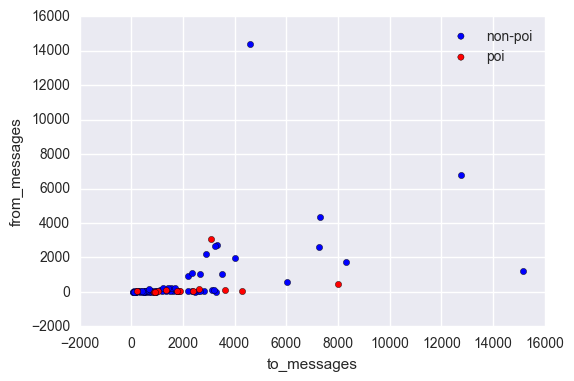

In [100]:
ax = dt[dt['poi'] == False].plot.scatter(x='to_messages', 
                                         y='from_messages', color='blue', label='non-poi')
dt[dt['poi'] == True].plot.scatter(x='to_messages', 
                                   y='from_messages', color='red', label='poi', ax=ax)

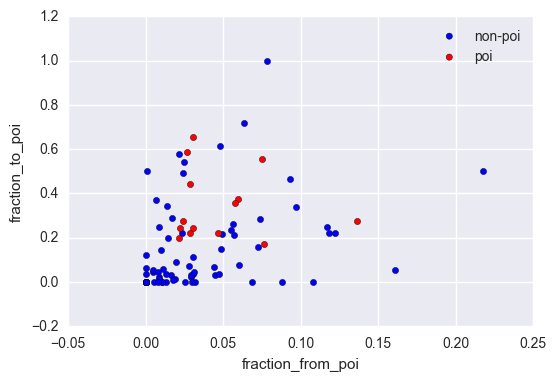

In [101]:
###creating new features 

dt['fraction_from_poi'] = dt['from_poi_to_this_person'] / dt['to_messages']
dt['fraction_to_poi'] = dt['from_this_person_to_poi'] / dt['from_messages']

ax = dt[dt['poi'] == False].plot.scatter(x='fraction_from_poi', 
                                         y='fraction_to_poi', color='blue', label='non-poi')
dt[dt['poi'] == True].plot.scatter(x='fraction_from_poi', 
                                   y='fraction_to_poi', color='red', label='poi', ax=ax)

In [102]:
#convert the numpy array to dict
dt.replace(np.nan, 'NaN', inplace = True)   
my_dataset=dt.to_dict(orient='index')


In [103]:
features_list = ['poi','fraction_from_poi','fraction_to_poi','salary', 'to_messages', 'deferral_payments', 
                 'total_payments', 'exercised_stock_options', 
  'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 
  'expenses', 'from_messages', 'other', 'from_this_person_to_poi', 
  'deferred_income', 'long_term_incentive', 'from_poi_to_this_person']

data = featureFormat(my_dataset, features_list,sort_keys = True)
labels, features = targetFeatureSplit(data)
print len(features_list)

19


In [104]:
from sklearn.feature_selection import SelectKBest, f_classif
#from sklearn.feature_selection import chi2
X, y = features,labels
scoring = SelectKBest(f_classif, k='all').fit(X,y)

print 'Feature Scoring:'
for feature_name,item in zip(features_list[1:] ,scoring.scores_ ):
    print feature_name,'',item


Feature Scoring:
fraction_from_poi  3.21076191697
fraction_to_poi  16.6417070705
salary  18.575703268
to_messages  1.69882434858
deferral_payments  0.21705893034
total_payments  8.86672153711
exercised_stock_options  25.0975415287
bonus  21.0600017075
restricted_stock  9.34670079105
shared_receipt_with_poi  8.74648553213
total_stock_value  24.4676540475
expenses  6.23420114051
from_messages  0.164164498234
other  4.2049708583
from_this_person_to_poi  2.42650812724
deferred_income  11.5955476597
long_term_incentive  10.0724545294
from_poi_to_this_person  5.34494152315


## Algorithm Selection and Tuning

>What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

>What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

My approach is to use an automated process to determine best features to use(KBest) and algorithm parameters(GridSearchCV),provided by Pipline() function. I tested a few algorithms including: Gaussian Naïve-Bayes, Decision Tree Classifier, K Nearest Neighbors Classifier, as well as ensemble learning Adaboost Classifier. Because this is an imbalenced data, the f1 score make more sense than accuracy, the best_esmator is perduced based on f1 score. <br />
A crucial part of building a machine learning algorithm is to adjust it’s parameters in order to maximize the evaluation metrics. If the parameters are not properly tuned, the algorithm can underfit or overfit the data, hence producing suboptimal results.<br />
To tune the algorithms, I used the GridSearchCV tool provided in scikit learn. It exhaustively searches for the best parameters between the ones specified in an array of possibilities. The parameters are chosen in order to optimize the chosen scoring function, in this case, in this case, f1 score. <br />

## Algorithm Validation

>What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]
Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

**Validation** in machine learning consists of evaluating a model using data that was not touched during the training process. Cross validation is often used for small dataset. An algorithm model without validation is at risk of obtaining overly optimistic results due to overfitting the training data, but very poor performance on unseen data. Several metrics are used for validation, each validation metrics has different meaning, misusage of validation metrics is a classic mistake one can make when validating machine learning models.

For classification algorithms, some of the most common evaluation metrics are accuracy, precision, recall and the f1 score.

Accuracy shows the ratio between right classifications and the total number of predicted labels. Since the POI/non-POI distribution is very uneven, accuracy does not mean much. A model that predicts always non-POI’s would get an accuracy of 87.6%, which is an apparently good score for a terrible classifier.

Precision is the ratio of right classifications over all observations with a given predicted label. For example, the ratio of true POI’s over all predicted POI’s.

Recall is the ratio of right classifications over all observations that are truly of a given class. For example, the ratio of observations correctly labeled POI over all true POI’s.

F1 is a way of balance precision and recall, and is given by the following formula:

$$F1 = 2 * (precision * recall) / (precision + recall)$$


test_classifier from tester.py was used for validation<br />
Algorithm performance: <br />
**Gaussian Naïve-Bayes**  precision:0.42579,  recall:0.33850,  F1: 0.37716

**Decision Tree Classifier**  precision_score      0.35934 , recall_scores        0.32700,F1:0.34241

**K Nearest Neighbors Classifier**  precision_score    0.55180, recall_scores      0.24500,F1: 0.33934

**Adaboost Classifier**  precision_score     0.32539, recall_scores       0.30050,F1: 0.31245

**Final Model**:
clf=GaussianNB()<br />
final_features_list=['exercised_stock_options','total_stock_value','bonus','salary','fraction_to_poi']

In [118]:
###Gaussian Naive-Bayes
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

folds = 100
kbest = SelectKBest(f_classif)

# A stratified shuffle split is used here to counter the effects of 
# the class imbalance problem
sss = StratifiedShuffleSplit(labels, folds, test_size=0.2, random_state = 42)
gnb = GaussianNB()

# A pipeline is used to chain the SelectKBest and algorithm.  
pipeline = Pipeline([('kbest', kbest), ('gnb', gnb)])

K_FEATURES = range(1,19)
K_FEATURES.append('all')

param_grid = {
    'kbest__k': K_FEATURES
}

gnb_grid_search = GridSearchCV(estimator = pipeline, 
                           param_grid = param_grid,
                        cv=sss,scoring='f1')

gnb_grid_search.fit(features, labels)

# Print the optimal value for k
print(gnb_grid_search.best_params_)

{'kbest__k': 5}


In [119]:
gnb_grid_search.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x1103f8050>)), ('gnb', GaussianNB())])

In [120]:
from tester import test_classifier
test_classifier(gnb_grid_search.best_estimator_, my_dataset, features_list)

Pipeline(steps=[('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x1103f8050>)), ('gnb', GaussianNB())])
	Accuracy: 0.85093	Precision: 0.42579	Recall: 0.33850	F1: 0.37716	F2: 0.35297
	Total predictions: 15000	True positives:  677	False positives:  913	False negatives: 1323	True negatives: 12087



In [121]:
###Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

folds = 100
kbest = SelectKBest(f_classif)

sss = StratifiedShuffleSplit(labels, folds, test_size=0.2, random_state = 42)
dtree = DecisionTreeClassifier(random_state = 42)
pipeline = Pipeline([('kbest', kbest), ('dtree', dtree)])


#K_FEATURES = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,'all']
MIN_SAMPLES = [2,3,4,5,6]
CRITERION = ['gini', 'entropy']


param_grid = {
    'kbest__k': K_FEATURES,
    'dtree__min_samples_split': MIN_SAMPLES,
    'dtree__criterion': CRITERION,
}

tree_grid_search = GridSearchCV(estimator = pipeline, 
                           param_grid = param_grid,
                        cv=sss,scoring='f1')

tree_grid_search.fit(features, labels)

# Print the optimal value for k
print(tree_grid_search.best_params_)

{'dtree__min_samples_split': 3, 'kbest__k': 12, 'dtree__criterion': 'entropy'}


In [122]:
tree_grid_search.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=12, score_func=<function f_classif at 0x1103f8050>)), ('dtree', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'))])

In [123]:

test_classifier(tree_grid_search.best_estimator_, my_dataset, features_list)

Pipeline(steps=[('kbest', SelectKBest(k=12, score_func=<function f_classif at 0x1103f8050>)), ('dtree', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'))])
	Accuracy: 0.83253	Precision: 0.35934	Recall: 0.32700	F1: 0.34241	F2: 0.33299
	Total predictions: 15000	True positives:  654	False positives: 1166	False negatives: 1346	True negatives: 11834



In [124]:
###KNeighborsClassifier

from sklearn.neighbors import KNeighborsClassifier

folds = 100
kbest = SelectKBest(f_classif)

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
scaled_features = min_max_scaler.fit_transform(features)


sss = StratifiedShuffleSplit(labels, folds, test_size=0.2, random_state = 42)

knn = KNeighborsClassifier()

pipeline = Pipeline([('kbest', kbest), ('knn', knn)])


#K_FEATURES = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,'all']
N_NEIGHBORS = [2,3,4,5,6]


param_grid = {
    'kbest__k': K_FEATURES,
    'knn__n_neighbors': N_NEIGHBORS
}

knn_grid_search = GridSearchCV(estimator = pipeline, 
                           param_grid = param_grid,
                        cv=sss,scoring='f1')

knn_grid_search.fit(scaled_features, labels)

# Print the optimal value for k
print(knn_grid_search.best_params_)

{'kbest__k': 3, 'knn__n_neighbors': 3}


In [125]:
knn_grid_search.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=3, score_func=<function f_classif at 0x1103f8050>)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'))])

In [126]:
test_classifier(knn_grid_search.best_estimator_, my_dataset, features_list)

Pipeline(steps=[('kbest', SelectKBest(k=3, score_func=<function f_classif at 0x1103f8050>)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'))])
	Accuracy: 0.87280	Precision: 0.55180	Recall: 0.24500	F1: 0.33934	F2: 0.27565
	Total predictions: 15000	True positives:  490	False positives:  398	False negatives: 1510	True negatives: 12602



In [127]:
###AdaBoostClassifier

from sklearn.ensemble import AdaBoostClassifier

folds = 10
kbest = SelectKBest(f_classif)

sss = StratifiedShuffleSplit(labels, folds, test_size=0.2, random_state = 42)

dtree = DecisionTreeClassifier(random_state = 42)
ada=AdaBoostClassifier(base_estimator=dtree,random_state = 42)

pipeline = Pipeline([('kbest', kbest),('ada', ada)])


#K_FEATURES = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,'all']
RATE = [2,3,4,5,6]
ESTIMATORS=[5,10,20,40,50]

param_grid = {
    'kbest__k': K_FEATURES,
        'ada__learning_rate': RATE,
    'ada__n_estimators':ESTIMATORS
}

ada_grid_search = GridSearchCV(estimator = pipeline, 
                           param_grid = param_grid,
                        cv=sss)

ada_grid_search.fit(features, labels)

# Print the optimal value for k
print(ada_grid_search.best_params_)

{'ada__n_estimators': 5, 'kbest__k': 10, 'ada__learning_rate': 2}


In [128]:
print ada_grid_search.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x1103f8050>)), ('ada', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=2, n_estimators=5, random_state=42))])


In [129]:
test_classifier(ada_grid_search.best_estimator_, my_dataset, features_list)

Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x1103f8050>)), ('ada', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=2, n_estimators=5, random_state=42))])
	Accuracy: 0.82367	Precision: 0.32539	Recall: 0.30050	F1: 0.31245	F2: 0.30517
	Total predictions: 15000	True positives:  601	False positives: 1246	False negatives: 1399	True negatives: 11754



### Reference

1.http://scikit-learn.org/stable/
2.http://nbviewer.jupyter.org/github/DariaAlekseeva/Enron_Dataset/blob/master/Enron%20POI%20Detector%20Project%20Assignment.ipynb
3.http://luizschiller.com/enron/